In [1]:
import json
from collections import defaultdict
from decimal import Decimal, ROUND_DOWN
import os


import numpy as np
import pandas as pd

import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')


In [2]:
from pymongo import MongoClient
import pandas as pd

# Configuração do MongoDB
client = MongoClient("mongodb://localhost:27017/")  # Substitua pela URI do seu banco de dados
db = client['trader_data']  # Nome do banco de dados
collection = db['order_book_snapshots_vidt_usdt']  # Nome da coleção

def load_existing_data_from_mongo():
    """
    Carrega os dados existentes do MongoDB.
    """
    try:
        # Buscar todos os documentos na coleção
        documents = collection.find()
        # Converter para uma lista
        return list(documents)
    except Exception as e:
        print(f"Erro ao carregar os dados do MongoDB: {e}")
        return []

def group_orderbook_by_tick(data, tick_size):
    """
    Agrupa bids e asks com base em um tick size especificado.
    """
    grouped_snapshots = []
    for snapshot in data:
        grouped_snapshot = snapshot.copy()
        # Agrupar bids
        grouped_snapshot["bids"] = [
            [round(float(bid[0]) / tick_size) * tick_size, bid[1]] for bid in snapshot["bids"]
        ]
        # Agrupar asks
        grouped_snapshot["asks"] = [
            [round(float(ask[0]) / tick_size) * tick_size, ask[1]] for ask in snapshot["asks"]
        ]
        grouped_snapshots.append(grouped_snapshot)
    return grouped_snapshots

# Carregar os dados existentes do MongoDB
existing_data = load_existing_data_from_mongo()

# Agrupar bids e asks com tick size de 0.01
tick_size = 0.00001
snapshots = group_orderbook_by_tick(existing_data, tick_size)[3500:]




In [3]:
# Criar o DataFrame (data)
data = pd.DataFrame(snapshots)

data["mid_price"] = [
    (float(snapshot["asks"][0][0]) + float(snapshot["bids"][0][0])) / 2 for snapshot in snapshots
]

# Exibir o DataFrame
data.head()

,_id,lastUpdateId,E,T,bids,asks,timestamp,mid_price
0,676c07ea89aa6baa76d49ca5,6224036541292,1734998964469,1734998964454,"[[0.033100000000000004, 39999], [0.03309, 6436...","[[0.033120000000000004, 28206], [0.03313, 7454...",2024-12-24T00:09:24.643121,0.033110
1,676c07ea89aa6baa76d49ca6,6224036814543,1734998967142,1734998967117,"[[0.03309, 38569], [0.033080000000000005, 5378...","[[0.03311, 15604], [0.033120000000000004, 7761...",2024-12-24T00:09:27.355003,0.033100
2,676c07ea89aa6baa76d49ca7,6224037042783,1734998969524,1734998969485,"[[0.033100000000000004, 560], [0.03309, 39280]...","[[0.03311, 17590], [0.033120000000000004, 7761...",2024-12-24T00:09:30.064427,0.033105
3,676c07ea89aa6baa76d49ca8,6224037303658,1734998972423,1734998972418,"[[0.03309, 35217], [0.033080000000000005, 5378...","[[0.03311, 24030], [0.033120000000000004, 5062...",2024-12-24T00:09:32.781770,0.033100
4,676c07ea89aa6baa76d49ca9,6224037607804,1734998975149,1734998975119,"[[0.03309, 34119], [0.033080000000000005, 5378...","[[0.03311, 24030], [0.033120000000000004, 5062...",2024-12-24T00:09:35.497844,0.033100


In [4]:

# ------------------------
# 1. Spread
# ------------------------
# Diferença entre o menor preço de venda (ask) e o maior preço de compra (bid).
data["spread"] = [float(snapshot["asks"][0][0]) - float(snapshot["bids"][0][0]) for snapshot in snapshots]

# ------------------------
# 2. Volume Total de Bids e Asks
# ------------------------
# Soma dos volumes de bids e asks para os 100 níveis.
data["total_bids_volume"] = [sum(float(bid[1]) for bid in snapshot["bids"]) for snapshot in snapshots]
data["total_asks_volume"] = [sum(float(ask[1]) for ask in snapshot["asks"]) for snapshot in snapshots]

# ------------------------
# 3. Desequilíbrio de Volume
# ------------------------
# Proporção do volume de bids em relação ao total de bids e asks.
data["volume_imbalance"] = data["total_bids_volume"] / (data["total_bids_volume"] + data["total_asks_volume"])

# ------------------------
# 4. Preço Médio Ponderado (Weighted Average Price - WAP)
# ------------------------
# Preço médio ponderado pelo volume para bids e asks.
def calculate_wap(levels):
    return sum(float(price) * float(volume) for price, volume in levels) / sum(float(volume) for _, volume in levels)

data["wap_bids"] = [calculate_wap(snapshot["bids"]) for snapshot in snapshots]
data["wap_asks"] = [calculate_wap(snapshot["asks"]) for snapshot in snapshots]

# ------------------------
# 5. Concentração de Volume
# ------------------------
# Mede a porcentagem do volume total presente em diferentes blocos do livro de ofertas (ex.: top 10, top 50, top 100).
def concentration(levels, total_volume, start, end):
    block_volume = sum(float(volume) for _, volume in levels[start:end])
    return block_volume / total_volume

data["bids_concentration_top10"] = [concentration(snapshot["bids"], total, 0, 10) for snapshot, total in zip(snapshots, data["total_bids_volume"])]
data["bids_concentration_top50"] = [concentration(snapshot["bids"], total, 0, 50) for snapshot, total in zip(snapshots, data["total_bids_volume"])]
data["bids_concentration_top100"] = [concentration(snapshot["bids"], total, 0, 100) for snapshot, total in zip(snapshots, data["total_bids_volume"])]

data["asks_concentration_top10"] = [concentration(snapshot["asks"], total, 0, 10) for snapshot, total in zip(snapshots, data["total_asks_volume"])]
data["asks_concentration_top50"] = [concentration(snapshot["asks"], total, 0, 50) for snapshot, total in zip(snapshots, data["total_asks_volume"])]
data["asks_concentration_top100"] = [concentration(snapshot["asks"], total, 0, 100) for snapshot, total in zip(snapshots, data["total_asks_volume"])]


# ------------------------
# 6. Consumo de Ordens por Nível
# ------------------------
# Calcula o consumo de bids e asks em cada nível entre snapshots consecutivos.
def calculate_level_consumption(snapshot_prev, snapshot_curr):
    bids_consumed_levels = []
    asks_consumed_levels = []

    # Calcular consumo de bids por nível
    for prev, curr in zip(snapshot_prev["bids"], snapshot_curr["bids"]):
        prev_volume = float(prev[1])
        curr_volume = float(curr[1])
        bids_consumed_levels.append(max(0, prev_volume - curr_volume))  # Apenas consumo positivo

    # Calcular consumo de asks por nível
    for prev, curr in zip(snapshot_prev["asks"], snapshot_curr["asks"]):
        prev_volume = float(prev[1])
        curr_volume = float(curr[1])
        asks_consumed_levels.append(max(0, prev_volume - curr_volume))  # Apenas consumo positivo

    return bids_consumed_levels, asks_consumed_levels



# Aplicar o cálculo em todos os snapshots
bids_consumed_levels_all = []
asks_consumed_levels_all = []

for i in range(1, len(snapshots)):
    bids_levels, asks_levels = calculate_level_consumption(snapshots[i - 1], snapshots[i])
    bids_consumed_levels_all.append(bids_levels)
    asks_consumed_levels_all.append(asks_levels)

# Adicionar resultados ao DataFrame
for level in range(100):
    data[f"bids_consumed_level_{level+1}"] = [0] + [bids[level] for bids in bids_consumed_levels_all]
    data[f"asks_consumed_level_{level+1}"] = [0] + [asks[level] for asks in asks_consumed_levels_all]
    
# ------------------------
# 7. Consumo Acumulado por Nível
# ------------------------
# Acumula o consumo por nível ao longo do tempo.
for level in range(100):
    data[f"bids_consumed_cumulative_level_{level+1}"] = data[f"bids_consumed_level_{level+1}"].cumsum()
    data[f"asks_consumed_cumulative_level_{level+1}"] = data[f"asks_consumed_level_{level+1}"].cumsum()

# ------------------------
# 8. Consumo Médio
# ------------------------
# Consumo médio instantâneo e acumulado considerando todos os 100 níveis.
data["bids_consumed_mean"] = data[[f"bids_consumed_level_{level+1}" for level in range(100)]].mean(axis=1)
data["asks_consumed_mean"] = data[[f"asks_consumed_level_{level+1}" for level in range(100)]].mean(axis=1)

data["bids_consumed_cumulative_mean"] = data[[f"bids_consumed_cumulative_level_{level+1}" for level in range(100)]].mean(axis=1)
data["asks_consumed_cumulative_mean"] = data[[f"asks_consumed_cumulative_level_{level+1}" for level in range(100)]].mean(axis=1)




In [5]:
data.head(1)

,_id,lastUpdateId,E,T,bids,asks,timestamp,mid_price,spread,total_bids_volume,...,bids_consumed_cumulative_level_98,asks_consumed_cumulative_level_98,bids_consumed_cumulative_level_99,asks_consumed_cumulative_level_99,bids_consumed_cumulative_level_100,asks_consumed_cumulative_level_100,bids_consumed_mean,asks_consumed_mean,bids_consumed_cumulative_mean,asks_consumed_cumulative_mean
0,676c07ea89aa6baa76d49ca5,6224036541292,1734998964469,1734998964454,"[[0.033100000000000004, 39999], [0.03309, 6436...","[[0.033120000000000004, 28206], [0.03313, 7454...",2024-12-24T00:09:24.643121,0.03311,0.00002,14382650.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.tail(1)

,_id,lastUpdateId,E,T,bids,asks,timestamp,mid_price,spread,total_bids_volume,...,bids_consumed_cumulative_level_98,asks_consumed_cumulative_level_98,bids_consumed_cumulative_level_99,asks_consumed_cumulative_level_99,bids_consumed_cumulative_level_100,asks_consumed_cumulative_level_100,bids_consumed_mean,asks_consumed_mean,bids_consumed_cumulative_mean,asks_consumed_cumulative_mean
48237,676cb21b33977e4f9e100c57,6243375193932,1735176731816,1735176731803,"[[0.0323, 27210], [0.03229, 72330], [0.03228, ...","[[0.032310000000000005, 16589], [0.03232, 7902...",2024-12-26T01:32:11.998274,0.032305,0.00001,22073141.0,...,2.279045e+09,1.462038e+09,2.313062e+09,1.480646e+09,2.359287e+09,1.361367e+09,2503.03,635.32,1.531547e+09,1.138395e+09


In [7]:


# b) Consumo por Nível
# Meça como os volumes em cada nível (ex.: top 3 ou top 5) estão sendo consumidos ao longo do tempo.

def calculate_level_consumption(snapshot_prev, snapshot_curr):
    # Consumo por nível (diferença entre volumes consecutivos)
    bids_consumed = [
        float(prev[1]) - float(curr[1]) for prev, curr in zip(snapshot_prev["bids"], snapshot_curr["bids"])
    ]
    asks_consumed = [
        float(prev[1]) - float(curr[1]) for prev, curr in zip(snapshot_prev["asks"], snapshot_curr["asks"])
    ]
    return sum(bids_consumed), sum(asks_consumed)

# Aplicar nos snapshots consecutivos
bids_consumed_per_level = [0]
asks_consumed_per_level = [0]
for i in range(1, len(snapshots)):
    bids, asks = calculate_level_consumption(snapshots[i - 1], snapshots[i])
    bids_consumed_per_level.append(bids)
    asks_consumed_per_level.append(asks)

data["bids_consumed_levels"] = bids_consumed_per_level
data["asks_consumed_levels"] = asks_consumed_per_level


# c) Velocidade Média de Consumo por Nível
# Mede o consumo por segundo em cada nível do livro.


time_interval = 1  # Intervalo entre snapshots (em segundos)

data["bids_velocity"] = data["bids_consumed_levels"] / time_interval
data["asks_velocity"] = data["asks_consumed_levels"] / time_interval

# Suavizar a velocidade de consumo
window = 1000  # Número de snapshots para suavização
data["smoothed_bids_velocity"] = data["bids_velocity"].rolling(window=window).mean()
data["smoothed_asks_velocity"] = data["asks_velocity"].rolling(window=window).mean()

# Direção do mercado baseada no desequilíbrio e consumo
data["market_direction"] = (
    data["volume_imbalance"] - 0.5  # Neutraliza o desequilíbrio para indicar direção
    + (data["smoothed_bids_velocity"] - data["smoothed_asks_velocity"]) / 2  # Consumo relativo
)


data["smoothed_direction"] = data["market_direction"].rolling(window=20).mean()


In [8]:
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['mid_price'], mode="lines", name="Preço Médio"))

# # Configuração do layout
# fig.update_layout(
#     title="Preço Médio do Order Book",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [9]:
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['smoothed_direction'], mode="lines", name="Volume imbalance"))

# # Configuração do layout
# fig.update_layout(
#     title="Volume imbalance",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [10]:
def calculate_level_consumption(snapshot_prev, snapshot_curr, start=0, end=None):
    if end is None:
        end = len(snapshot_prev["bids"])  # Considera todos os níveis por padrão
    # Consumo por nível (diferença entre volumes consecutivos)
    bids_consumed = [
        float(prev[1]) - float(curr[1]) for prev, curr in zip(snapshot_prev["bids"][start:end], snapshot_curr["bids"][start:end])
    ]
    asks_consumed = [
        float(prev[1]) - float(curr[1]) for prev, curr in zip(snapshot_prev["asks"][start:end], snapshot_curr["asks"][start:end])
    ]
    return sum(bids_consumed), sum(asks_consumed)

# Aplicar o cálculo em blocos específicos
block_definitions = [
    (0, 10, "top10"),
    (0, 50, "top50"),
    (0, 100, "top100")
]  # Definição para cobrir todos os 100 níveis
block_bids_consumed = {block_label: [] for _, _, block_label in block_definitions}
block_asks_consumed = {block_label: [] for _, _, block_label in block_definitions}

# Iterar sobre snapshots consecutivos
len_prev = 1
for i in range(len_prev, len(snapshots)):
    for start, end, block_label in block_definitions:
        bids, asks = calculate_level_consumption(snapshots[i - len_prev], snapshots[i], start, end)
        block_bids_consumed[block_label].append(bids)
        block_asks_consumed[block_label].append(asks)

# Adicionar resultados ao DataFrame
for _, _, block_label in block_definitions:
    data[f"bids_consumed_{block_label}"] = len_prev*[0] + block_bids_consumed[block_label]
    data[f"asks_consumed_{block_label}"] = len_prev*[0] + block_asks_consumed[block_label]

# ------------------------
# Velocidade e Suavização
# ------------------------
# Intervalo entre snapshots (em segundos)
time_interval = 1

# Velocidade de consumo para cada bloco
for _, _, block_label in block_definitions:
    data[f"bids_velocity_{block_label}"] = data[f"bids_consumed_{block_label}"] / time_interval
    data[f"asks_velocity_{block_label}"] = data[f"asks_consumed_{block_label}"] / time_interval

# Suavização da velocidade por bloco
velocity_window = 500  # Número de snapshots para suavização
for _, _, block_label in block_definitions:
    data[f"smoothed_bids_velocity_{block_label}"] = data[f"bids_velocity_{block_label}"].rolling(window=velocity_window).mean()
    data[f"smoothed_asks_velocity_{block_label}"] = data[f"asks_velocity_{block_label}"].rolling(window=velocity_window).mean()

# ------------------------
# Market Direction
# ------------------------
# Combinar desequilíbrio e velocidades suavizadas por bloco para um market direction granular.
market_direction_components = []

for _, _, block_label in block_definitions:
    component = (
        (data[f"smoothed_bids_velocity_{block_label}"] - data[f"smoothed_asks_velocity_{block_label}"]) / 1
    )
    market_direction_components.append(component)

# Combinar todos os blocos em um único indicador de direção
data["market_direction_block"] = data["volume_imbalance"] - 0.5 + sum(market_direction_components)/len(block_definitions)


# Suavizar o Market Direction
market_direction_window = 20
data["smoothed_market_direction"] = data["market_direction_block"].rolling(window=market_direction_window).mean()


weighted_direction = (
    1.8 * (data["smoothed_bids_velocity_top10"] - data["smoothed_asks_velocity_top10"]) +
    1.5 * (data["smoothed_bids_velocity_top50"] - data["smoothed_asks_velocity_top50"]) +
    1.1 * (data["smoothed_bids_velocity_top100"] - data["smoothed_asks_velocity_top100"])
)
data["weighted_market_direction"] = data["volume_imbalance"] - 0.5 + weighted_direction/len(block_definitions)
data["weighted_market_direction"] = data["weighted_market_direction"].rolling(window=market_direction_window).mean()


In [11]:
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['weighted_market_direction'], mode="lines", name="normal"))
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['smoothed_market_direction'], mode="lines", name="normal"))

# # Configuração do layout
# fig.update_layout(
#     title="Volume imbalance",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [12]:
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['mid_price'], mode="lines", name="Preço Médio"))

# # Configuração do layout
# fig.update_layout(
#     title="Preço Médio do Order Book",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Função para detectar suportes e resistências

def detect_support_resistance(snapshot, threshold_multiplier=2):
    """
    Detecta suportes e resistências com base no volume acumulado nos níveis de ask e bid.
    
    snapshot: O snapshot atual do livro de ofertas.
    threshold_multiplier: Multiplicador usado para determinar o quanto um nível precisa estar acima da média para ser um suporte ou resistência.
    
    Retorna:
    suportes, resistências: Listas de preços marcados como suportes (-1) ou resistências (1).
    """
    # Extrair os níveis de ask e bid
    asks = [(float(level[0]), float(level[1])) for level in snapshot["asks"]]
    bids = [(float(level[0]), float(level[1])) for level in snapshot["bids"]]

    # Calcular a média de volume para ask e bid
    avg_ask_volume = sum(volume for _, volume in asks) / len(asks)
    avg_bid_volume = sum(volume for _, volume in bids) / len(bids)

    # Determinar thresholds
    ask_threshold = avg_ask_volume * threshold_multiplier
    bid_threshold = avg_bid_volume * threshold_multiplier

    # Identificar resistências (ask acima do threshold)
    resistances = [price for price, volume in asks if volume > ask_threshold]

    # Identificar suportes (bid acima do threshold)
    supports = [price for price, volume in bids if volume > bid_threshold]

    return supports, resistances

# Adicionar os suportes e resistências ao DataFrame
support_resistance = []
threshold= 5
for snapshot in snapshots:
    supports, resistances = detect_support_resistance(snapshot, threshold)
    support_resistance.append((supports, resistances))

data["supports"] = [item[0] for item in support_resistance]
data["resistances"] = [item[1] for item in support_resistance]



# Função para gerar vetor de suporte e resistência

def mark_support_resistance(snapshot, supports, resistances):
    """
    Marca os níveis de suporte e resistência em um vetor com 1 para resistências e -1 para suportes.
    """
    levels = {price: 1 for price in resistances}  # Resistência marcada como 1
    levels.update({price: -1 for price in supports})  # Suporte marcado como -1
    
    return levels

support_resistance_vector = []



for snapshot, row in zip(snapshots, data.itertuples()):
    vector = mark_support_resistance(snapshot, row.supports, row.resistances)
    support_resistance_vector.append(vector)

# Adicionar vetor ao DataFrame
data["support_resistance_vector"] = support_resistance_vector



In [14]:
# ------------------------
# Plotar preço médio, suportes e resistências (otimizado)
# ------------------------

# plt.figure(figsize=(12, 6))

# # Preço médio
# plt.plot(data.index, data["mid_price"], label="Preço Médio", color="blue")

# # Armazenar suportes e resistências para plotagem em lote
# support_points_x = []
# support_points_y = []
# resistance_points_x = []
# resistance_points_y = []

# # Iterar sobre o DataFrame e coletar pontos
# for i, row in data.iterrows():
#     if row["supports"]:
#         support_points_x.extend([i] * len(row["supports"]))
#         support_points_y.extend(row["supports"])
#     if row["resistances"]:
#         resistance_points_x.extend([i] * len(row["resistances"]))
#         resistance_points_y.extend(row["resistances"])

# # Plotar suportes e resistências em lote
# plt.scatter(support_points_x, support_points_y, color="green", label="Suporte")
# plt.scatter(resistance_points_x, resistance_points_y, color="red", label="Resistência")

# # Configurações do gráfico
# plt.xlabel("Snapshot")
# plt.ylabel("Preço")
# plt.title("Preço Médio com Suportes e Resistências")
# plt.legend()
# plt.show()


In [15]:
# Função corrigida para consumo acumulado
def calculate_level_consumption(snapshot_prev, snapshot_curr, start=0, end=None):
    if end is None:
        end = len(snapshot_prev["bids"])  # Considera todos os níveis por padrão

    # Calcular consumo de bids
    bids_consumed = [
        max(0, float(prev[1]) - float(curr[1]))  # Consumo positivo apenas
        for prev, curr in zip(snapshot_prev["bids"][start:end], snapshot_curr["bids"][start:end])
    ]
    # Calcular consumo de asks
    asks_consumed = [
        max(0, float(prev[1]) - float(curr[1]))  # Consumo positivo apenas
        for prev, curr in zip(snapshot_prev["asks"][start:end], snapshot_curr["asks"][start:end])
    ]
    return sum(bids_consumed), sum(asks_consumed)

# Aplicar o cálculo em blocos específicos
block_definitions = [
    (0, 10, "top10"),
    (0, 50, "top50"),
    (0, 100, "top100")
]  # Definição para cobrir todos os 100 níveis
block_bids_consumed = {block_label: [] for _, _, block_label in block_definitions}
block_asks_consumed = {block_label: [] for _, _, block_label in block_definitions}

# Iterar sobre snapshots consecutivos
len_prev = 1
for i in range(len_prev, len(snapshots)):
    for start, end, block_label in block_definitions:
        bids, asks = calculate_level_consumption(snapshots[i - len_prev], snapshots[i], start, end)
        block_bids_consumed[block_label].append(bids)
        block_asks_consumed[block_label].append(asks)

# Adicionar resultados ao DataFrame
for _, _, block_label in block_definitions:
    data[f"bids_consumed_{block_label}"] = len_prev*[0] + block_bids_consumed[block_label]
    data[f"asks_consumed_{block_label}"] = len_prev*[0] + block_asks_consumed[block_label]


# Tamanho da janela deslizante (número de snapshots)
window_size = 50  # Ajuste conforme necessário

# Consumo acumulado em janela deslizante para bids
data["bids_consumed_cumulative_window"] = (
    data["bids_consumed_top10"].rolling(window=window_size).sum() +
    data["bids_consumed_top50"].rolling(window=window_size).sum() +
    data["bids_consumed_top100"].rolling(window=window_size).sum()
)

# Consumo acumulado em janela deslizante para asks
data["asks_consumed_cumulative_window"] = (
    data["asks_consumed_top10"].rolling(window=window_size).sum() +
    data["asks_consumed_top50"].rolling(window=window_size).sum() +
    data["asks_consumed_top100"].rolling(window=window_size).sum()
)


In [16]:
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['bids_consumed_cumulative_window'], mode="lines", name="bid"))
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['asks_consumed_cumulative_window'], mode="lines", name="ask"))

# # Configuração do layout
# fig.update_layout(
#     title="Preço Médio do Order Book",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [17]:
data["spread_consumed_cumulative_window"] = data["bids_consumed_cumulative_window"] - data["asks_consumed_cumulative_window"]
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['spread_consumed_cumulative_window'], mode="lines", name="bid"))

# # Configuração do layout
# fig.update_layout(
#     title="Preço Médio do Order Book",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [18]:
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['mid_price'], mode="lines", name="Preço Médio"))

# # Configuração do layout
# fig.update_layout(
#     title="Preço Médio do Order Book",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [19]:
# Normalização Min-Max
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

data["volume_imbalance_norm"] = min_max_normalize(data["volume_imbalance"])
data["bids_consumed_cumulative_window_norm"] = min_max_normalize(data["bids_consumed_cumulative_window"])
data["asks_consumed_cumulative_window_norm"] = min_max_normalize(data["asks_consumed_cumulative_window"])
data["spread_consumed_cumulative_window_norm"] = min_max_normalize(data["spread_consumed_cumulative_window"])



# Peso para os componentes
imbalance_weight = 0.5
cumulative_weight = 0.3
spread_weight = 0.2

# Calcular o novo market_direction
data["enhanced_market_direction"] = (
    (data["volume_imbalance_norm"] - 0.5) * imbalance_weight +  # Desequilíbrio de volume
    (data["bids_consumed_cumulative_window_norm"] - data["asks_consumed_cumulative_window_norm"]) * cumulative_weight +  # Consumo acumulado
    data["spread_consumed_cumulative_window_norm"] * spread_weight  # Spread acumulado
)

# Suavizar o novo market_direction
market_direction_window = 20
data["smoothed_enhanced_market_direction"] = data["enhanced_market_direction"].rolling(window=market_direction_window).mean()



In [20]:
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['smoothed_enhanced_market_direction'], mode="lines", name="Preço Médio"))

# # Configuração do layout
# fig.update_layout(
#     title="Preço Médio do Order Book",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [21]:
# b) Consumo por Nível (Sequencial)
# Meça como os volumes em cada nível (ex.: top 3 ou top 5) estão sendo consumidos ao longo do tempo de forma sequencial.

def calculate_sequential_consumption(snapshot_prev, snapshot_curr):
    """
    Calcula o consumo válido sequencialmente em todos os níveis do livro de ofertas.
    O consumo em um nível só é considerado se o nível anterior tiver sido consumido.
    """
    bids_consumed = 0
    asks_consumed = 0

    # Verificar consumo sequencial para bids
    previous_bid_consumed = False  # Controle para verificar sequência
    for prev, curr in zip(snapshot_prev["bids"], snapshot_curr["bids"]):
        bid_diff = max(0, float(prev[1]) - float(curr[1]))
        if previous_bid_consumed or bid_diff > 0:  # Consumo é válido se anterior foi consumido
            bids_consumed += bid_diff
            previous_bid_consumed = True  # Marca que este nível foi consumido
        else:
            break  # Interrompe se o consumo não foi sequencial

    # Verificar consumo sequencial para asks
    previous_ask_consumed = False  # Controle para verificar sequência
    for prev, curr in zip(snapshot_prev["asks"], snapshot_curr["asks"]):
        ask_diff = max(0, float(prev[1]) - float(curr[1]))
        if previous_ask_consumed or ask_diff > 0:  # Consumo é válido se anterior foi consumido
            asks_consumed += ask_diff
            previous_ask_consumed = True  # Marca que este nível foi consumido
        else:
            break  # Interrompe se o consumo não foi sequencial

    return bids_consumed, asks_consumed

# Aplicar nos snapshots consecutivos
bids_consumed_per_level = [0]
asks_consumed_per_level = [0]
for i in range(1, len(snapshots)):
    bids, asks = calculate_sequential_consumption(snapshots[i - 1], snapshots[i])
    bids_consumed_per_level.append(bids)
    asks_consumed_per_level.append(asks)

data["bids_consumed_levels"] = bids_consumed_per_level
data["asks_consumed_levels"] = asks_consumed_per_level

# c) Velocidade Média de Consumo por Nível
# Mede o consumo por segundo em cada nível do livro.

time_interval = 1  # Intervalo entre snapshots (em segundos)

data["bids_velocity"] = data["bids_consumed_levels"] / time_interval
data["asks_velocity"] = data["asks_consumed_levels"] / time_interval

# Suavizar a velocidade de consumo
window = 100  # Número de snapshots para suavização
data["smoothed_bids_velocity"] = data["bids_velocity"].rolling(window=window).mean()
data["smoothed_asks_velocity"] = data["asks_velocity"].rolling(window=window).mean()

# data["market_direction"] = (
#     + (data["smoothed_bids_velocity"] - data["smoothed_asks_velocity"]) / 1  # Consumo relativo
# )
data["market_direction"] = (
    (data["smoothed_bids_velocity"] - data["smoothed_asks_velocity"]) /
    (data["smoothed_bids_velocity"] + data["smoothed_asks_velocity"] + 1e-9)  # Evita divisão por zero
)

data["smoothed_direction"] = data["market_direction"].rolling(window=10).mean()


In [22]:
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['smoothed_direction'], mode="lines", name="Preço Médio"))
# # fig.add_trace(go.Scatter(x=data['timestamp'], y=data['smoothed_asks_velocity'], mode="lines", name="Preço Médio"))

# # Configuração do layout
# fig.update_layout(
#     title="Preço Médio do Order Book",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [23]:

def calculate_level_consumption(snapshot_prev, snapshot_curr, start=0, end=None):
    if end is None:
        end = len(snapshot_prev["bids"])  # Considera todos os níveis por padrão
    # Consumo por nível (diferença entre volumes consecutivos)
    bids_consumed = [
        float(prev[1]) - float(curr[1]) for prev, curr in zip(snapshot_prev["bids"][start:end], snapshot_curr["bids"][start:end])
    ]
    asks_consumed = [
        float(prev[1]) - float(curr[1]) for prev, curr in zip(snapshot_prev["asks"][start:end], snapshot_curr["asks"][start:end])
    ]
    return sum(bids_consumed), sum(asks_consumed)


# Aplicar o cálculo em blocos específicos
block_definitions = [
    (0, 10, "top10"),
    (0, 50, "top50"),
    (0, 100, "top100")
]  # Definição para cobrir todos os 100 níveis
block_bids_consumed = {block_label: [] for _, _, block_label in block_definitions}
block_asks_consumed = {block_label: [] for _, _, block_label in block_definitions}

# Iterar sobre snapshots consecutivos
len_prev = 1
for i in range(len_prev, len(snapshots)):
    for start, end, block_label in block_definitions:
        bids, asks = calculate_level_consumption(snapshots[i - len_prev], snapshots[i], start, end)
        block_bids_consumed[block_label].append(bids)
        block_asks_consumed[block_label].append(asks)

# Adicionar resultados ao DataFrame
for _, _, block_label in block_definitions:
    data[f"bids_consumed_{block_label}"] = len_prev*[0] + block_bids_consumed[block_label]
    data[f"asks_consumed_{block_label}"] = len_prev*[0] + block_asks_consumed[block_label]


# Tamanho da janela deslizante (número de snapshots)
window_size = 10  # Ajuste conforme necessário

# Consumo acumulado em janela deslizante para bids
data["bids_consumed_cumulative_window"] = (
    data["bids_consumed_top10"].rolling(window=window_size).sum() +
    data["bids_consumed_top50"].rolling(window=window_size).sum() +
    data["bids_consumed_top100"].rolling(window=window_size).sum()
)

# Consumo acumulado em janela deslizante para asks
data["asks_consumed_cumulative_window"] = (
    data["asks_consumed_top10"].rolling(window=window_size).sum() +
    data["asks_consumed_top50"].rolling(window=window_size).sum() +
    data["asks_consumed_top100"].rolling(window=window_size).sum()
)

time_interval = 1  # Intervalo entre snapshots (em segundos)

data["bids_velocity"] = data["bids_consumed_cumulative_window"] / time_interval
data["asks_velocity"] = data["asks_consumed_cumulative_window"] / time_interval

# Suavizar a velocidade de consumo



window = 1000 # Número de snapshots para suavização
data["smoothed_bids_velocity"] = data["bids_velocity"].rolling(window=window).mean()
data["smoothed_asks_velocity"] = data["asks_velocity"].rolling(window=window).mean()

# Direção do mercado baseada no desequilíbrio e consumo
data["market_direction"] = (
    + (data["smoothed_bids_velocity"] - data["smoothed_asks_velocity"]) / 1  # Consumo relativo
)
# data["market_direction"] = (
#     (data["smoothed_bids_velocity"] - data["smoothed_asks_velocity"]) /
#     (data["smoothed_bids_velocity"] + data["smoothed_asks_velocity"] + 1e-9)  # Evita divisão por zero
# )

data["smoothed_direction"] = data["market_direction"].rolling(window=50).mean()


In [24]:
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['smoothed_direction'], mode="lines", name="Preço Médio"))

# # Configuração do layout
# fig.update_layout(
#     title="Preço Médio do Order Book",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [25]:
# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['mid_price'], mode="lines", name="Preço Médio"))

# # Configuração do layout
# fig.update_layout(
#     title="Preço Médio do Order Book",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [26]:
list(data.columns)

['_id',
 'lastUpdateId',
 'E',
 'T',
 'bids',
 'asks',
 'timestamp',
 'mid_price',
 'spread',
 'total_bids_volume',
 'total_asks_volume',
 'volume_imbalance',
 'wap_bids',
 'wap_asks',
 'bids_concentration_top10',
 'bids_concentration_top50',
 'bids_concentration_top100',
 'asks_concentration_top10',
 'asks_concentration_top50',
 'asks_concentration_top100',
 'bids_consumed_level_1',
 'asks_consumed_level_1',
 'bids_consumed_level_2',
 'asks_consumed_level_2',
 'bids_consumed_level_3',
 'asks_consumed_level_3',
 'bids_consumed_level_4',
 'asks_consumed_level_4',
 'bids_consumed_level_5',
 'asks_consumed_level_5',
 'bids_consumed_level_6',
 'asks_consumed_level_6',
 'bids_consumed_level_7',
 'asks_consumed_level_7',
 'bids_consumed_level_8',
 'asks_consumed_level_8',
 'bids_consumed_level_9',
 'asks_consumed_level_9',
 'bids_consumed_level_10',
 'asks_consumed_level_10',
 'bids_consumed_level_11',
 'asks_consumed_level_11',
 'bids_consumed_level_12',
 'asks_consumed_level_12',
 'bids_co

In [27]:
# data["spread_concentration"] = data['bids_concentration_top10'] - data['asks_concentration_top10']

# # Criação do gráfico
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=data['timestamp'], y=data['spread_concentration'], mode="lines", name="bid"))
# # fig.add_trace(go.Scatter(x=data['timestamp'], y=data['asks_concentration_top10'], mode="lines", name="ask"))

# # Configuração do layout
# fig.update_layout(
#     title="Preço Médio do Order Book",
#     xaxis_title="Timestamp",
#     yaxis_title="Preço Médio",
#     template="plotly_white",
# )

# # Exibição do gráfico
# fig.show()

In [28]:
[1,2,3]+[2,3,4]

[1, 2, 3, 2, 3, 4]

In [170]:
# Configurações ajustadas
target_profit = 0.005  # 0.3%
stop_loss = 0.002      # 0.4%
N = 10                 # Próximos 50 snapshots

# Função ajustada para calcular o target
def calculate_target(data, N, target_profit, stop_loss):
    # Inicializar a lista de targets
    targets = []
    for i in range(len(data) - N):
        # Preço atual
        mid_price_now = data["mid_price"].iloc[i]
        # Preços futuros
        future_prices = data["mid_price"].iloc[i + 1 : i + N + 1]

        # Máximo e mínimo no intervalo
        max_price = future_prices.max()
        min_price = future_prices.min()

        # Lucros e perdas potenciais
        profit_up = (max_price - mid_price_now) / mid_price_now  # Lucro para compra
        loss_down = (min_price - mid_price_now) / mid_price_now  # Perda para compra
        profit_down = (mid_price_now - min_price) / mid_price_now  # Lucro para venda
        loss_up = (mid_price_now - max_price) / mid_price_now  # Perda para venda

        # Classificar target com classes intermediárias
        if profit_up >= target_profit and loss_down > -stop_loss:
            targets.append(1)  # Compra forte
        # elif profit_up >= 0.005 and loss_down > -0.005:
        #     targets.append(3)  # Compra moderada
        elif profit_down >= target_profit and loss_up > -stop_loss:
            targets.append(2)  # Venda forte
        # elif profit_down >= 0.005 and loss_up > -0.005:
        #     targets.append(4)  # Venda moderada
        else:
            targets.append(0)  # Nenhum sinal

    return targets + [None]*N

# Aplicando a função
data["target"] = calculate_target(data, N, target_profit, stop_loss)


In [171]:
data.dropna(inplace=True)
data["target"].value_counts()

target
0.0    39753
1.0      928
2.0      900
Name: count, dtype: int64

In [172]:
# import plotly.graph_objects as go

# # Criar o gráfico de linhas para o preço médio
# fig = go.Figure()
# fig.add_trace(go.Scatter(
#     x=data.index,  # Index do DataFrame
#     y=data["mid_price"],
#     mode="lines",
#     name="Preço Médio",
#     line=dict(color="blue")
# ))

# # Adicionar os targets de compra (1)
# fig.add_trace(go.Scatter(
#     x=data[data["target"] == 1].index,  # Index dos targets 1
#     y=data[data["target"] == 1]["mid_price"],
#     mode="markers",
#     name="Target: Compra (1)",
#     marker=dict(color="green", size=8, symbol="triangle-up")
# ))

# # Adicionar os targets de venda (2)
# fig.add_trace(go.Scatter(
#     x=data[data["target"] == 2].index,  # Index dos targets 2
#     y=data[data["target"] == 2]["mid_price"],
#     mode="markers",
#     name="Target: Venda (2)",
#     marker=dict(color="red", size=8, symbol="triangle-down")
# ))

# # Configurar layout
# fig.update_layout(
#     title="Preço Médio e Targets",
#     xaxis_title="Snapshots",
#     yaxis_title="Preço Médio",
#     legend_title="Legenda",
#     template="plotly_white"
# )

# # Mostrar o gráfico
# fig.show()


In [173]:
selected_features = [
    "mid_price", "spread", "volume_imbalance",
    "bids_velocity", "asks_velocity",
    "smoothed_bids_velocity", "smoothed_asks_velocity",
    "market_direction", "smoothed_market_direction", 
     'bids_concentration_top10',
 'bids_concentration_top50',
 'bids_concentration_top100',
 'asks_concentration_top10',
 'asks_concentration_top50',
 'asks_concentration_top100',
    'bids_consumed_mean',
 'asks_consumed_mean',
 'bids_consumed_cumulative_mean',
 'asks_consumed_cumulative_mean',
    'bids_consumed_top10',
 'asks_consumed_top10',
 'bids_consumed_top50',
 'asks_consumed_top50',
 'bids_consumed_top100',
 'asks_consumed_top100',
 'bids_velocity_top10',
 'asks_velocity_top10',
 'bids_velocity_top50',
 'asks_velocity_top50',
 'bids_velocity_top100',
 'asks_velocity_top100',
 'smoothed_bids_velocity_top10',
 'smoothed_asks_velocity_top10',
 'smoothed_bids_velocity_top50',
 'smoothed_asks_velocity_top50',
 'smoothed_bids_velocity_top100',
 'smoothed_asks_velocity_top100',
]

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Carregar os dados
# Assumindo que o DataFrame "data" já contém as features e o target
# Assegure-se de que "target" tenha valores categóricos (0, 1, 2 para classificação)
# Excluir colunas não numéricas ou irrelevantes
features = [col for col in data[selected_features].columns if col != "target"]
X = data[features].values
y = data["target"].values

In [174]:
X.shape

(41581, 37)

In [175]:
y

array([0., 0., 0., ..., 0., 0., 0.])

In [181]:


# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, shuffle=False)

# Para classificação multiclasse, crie rótulos one-hot para redes neurais
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)


In [182]:
unique1, frequency1 = np.unique(y_train, return_counts = True)
unique2, frequency2 = np.unique(y_test, return_counts = True)

In [183]:
frequency1, frequency2

(array([11660,   515,   299]), array([28093,   413,   601]))

In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Treinamento do Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Previsões e avaliação
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Acurácia do Random Forest:", accuracy_rf)
print(classification_report(y_test, y_pred_rf))


Acurácia do Random Forest: 0.9651630192050022
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     28093
         1.0       0.50      0.00      0.01       413
         2.0       0.00      0.00      0.00       601

    accuracy                           0.97     29107
   macro avg       0.49      0.33      0.33     29107
weighted avg       0.94      0.97      0.95     29107



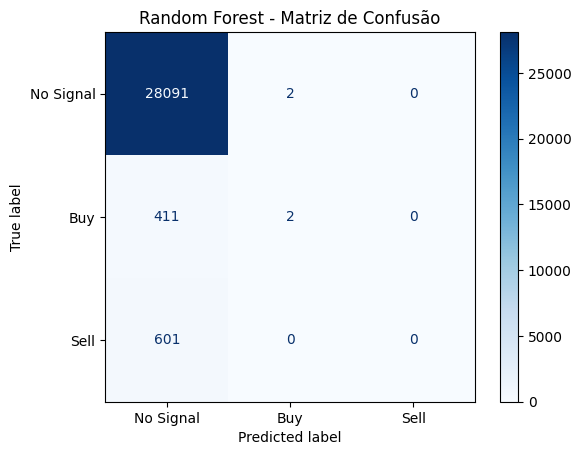

In [185]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Matriz de confusão - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Signal", "Buy", "Sell"])
disp_rf.plot(cmap="Blues")
plt.title("Random Forest - Matriz de Confusão")
plt.show()

In [186]:
from xgboost import XGBClassifier

# Treinamento do XGBoost
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Previsões e avaliação
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print("Acurácia do XGBoost:", accuracy_xgb)
print(classification_report(y_test, y_pred_xgb))


Acurácia do XGBoost: 0.965128663208163
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     28093
         1.0       0.00      0.00      0.00       413
         2.0       0.00      0.00      0.00       601

    accuracy                           0.97     29107
   macro avg       0.32      0.33      0.33     29107
weighted avg       0.93      0.97      0.95     29107



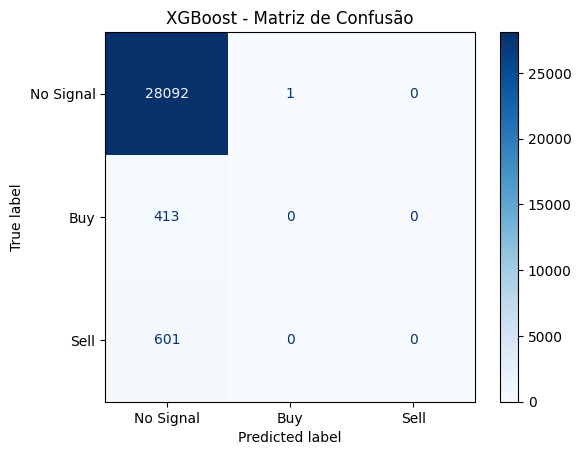

In [188]:
# Matriz de confusão - XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["No Signal", "Buy", "Sell"])
disp_xgb.plot(cmap="Blues")
plt.title("XGBoost - Matriz de Confusão")
plt.show()

In [189]:
# Reestruturar os dados para sequências temporais
n_timesteps = 100  # Número de snapshots usados para prever o próximo movimento
n_features = X_train.shape[1]

def create_sequences(X, y, n_timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_timesteps):
        X_seq.append(X[i:i+n_timesteps])
        y_seq.append(y[i+n_timesteps])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train_categorical, n_timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test_categorical, n_timesteps)

# Modelo LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential([
    LSTM(50, activation='tanh', input_shape=(n_timesteps, n_features)),
    Dense(3, activation='softmax')  # 3 classes (0, 1, 2)
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinamento do modelo
lstm_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.2)

# Avaliação do modelo
loss, accuracy_lstm = lstm_model.evaluate(X_test_seq, y_test_seq)
print("Acurácia do LSTM:", accuracy_lstm)


Epoch 1/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8853 - loss: 0.3786 - val_accuracy: 0.8384 - val_loss: 0.5244
Epoch 2/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9517 - loss: 0.1734 - val_accuracy: 0.7980 - val_loss: 0.6072
Epoch 3/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9598 - loss: 0.1346 - val_accuracy: 0.8170 - val_loss: 0.5549
Epoch 4/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9648 - loss: 0.1049 - val_accuracy: 0.7495 - val_loss: 0.6424
Epoch 5/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9736 - loss: 0.0784 - val_accuracy: 0.7568 - val_loss: 0.6502
Epoch 6/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9786 - loss: 0.0644 - val_accuracy: 0.7891 - val_loss: 0.5982
Epoch 7/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9807 - loss: 0.0553 - val_accuracy: 0.7648 - val_loss: 0.6181
Epoch 8/10
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9857 - loss: 0.0412 - val_accu

907/907 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


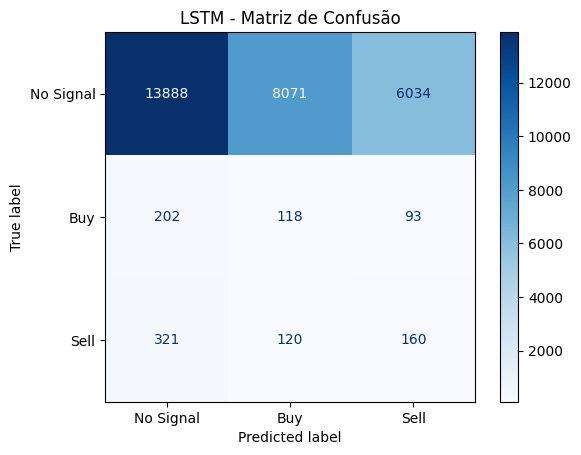

In [190]:
# Previsões do LSTM
y_pred_lstm = lstm_model.predict(X_test_seq)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)  # Converter para classes
y_test_classes = np.argmax(y_test_seq, axis=1)  # Converter y_test para classes

# Matriz de confusão - LSTM
cm_lstm = confusion_matrix(y_test_classes, y_pred_lstm_classes)
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=["No Signal", "Buy", "Sell"])
disp_lstm.plot(cmap="Blues")
plt.title("LSTM - Matriz de Confusão")
plt.show()

In [154]:
# Assumindo que X é o conjunto de dados com as features
n_features = X_train.shape[1]

# Reformatar para incluir a dimensão de canal (necessária para CNN)
X_train_cnn = X_train.reshape(-1, n_features, 1)  # (n_amostras, n_features, 1)
X_test_cnn = X_test.reshape(-1, n_features, 1)



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense

# Construir a CNN
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(n_features, 1)),  # Convolução 1D
    Flatten(),
    Dense(5, activation='softmax')  # 3 classes para classificação
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinamento do modelo
cnn_model.fit(X_train_cnn, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)

# Avaliação do modelo
loss, accuracy_cnn = cnn_model.evaluate(X_test_cnn, y_test_categorical)
print("Acurácia do CNN:", accuracy_cnn)





Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7333 - loss: 0.8442 - val_accuracy: 0.7698 - val_loss: 0.8895
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.7664 - loss: 0.6749 - val_accuracy: 0.7036 - val_loss: 0.9731
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.7738 - loss: 0.6429 - val_accuracy: 0.6825 - val_loss: 1.0398
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.7847 - loss: 0.6168 - val_accuracy: 0.7000 - val_loss: 1.0498
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.7811 - loss: 0.6102 - val_accuracy: 0.6817 - val_loss: 1.0949
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.7796 - loss: 0.6059 - val_accuracy: 0.6641 - val_loss: 1.1679
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.7868 - loss: 0.5925 - val_accuracy: 0.6893 - val_loss: 1.1893
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.7826 - loss: 0.5882 - va

914/914 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (3).

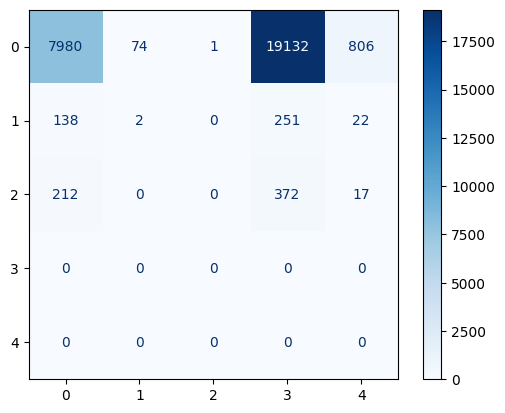

In [191]:
# Previsões do CNN
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Ajustar y_test_classes para ter o mesmo tamanho de y_pred_cnn_classes
min_length = min(len(y_test_classes), len(y_pred_cnn_classes))

y_test_classes = y_test_classes[:min_length]
y_pred_cnn_classes = y_pred_cnn_classes[:min_length]


# Matriz de confusão - CNN
cm_cnn = confusion_matrix(y_test_classes, y_pred_cnn_classes)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=["No Signal", "Buy", "Sell"])
disp_cnn.plot(cmap="Blues")
plt.title("CNN - Matriz de Confusão")
plt.show()

In [156]:
# Criar sequências temporais
n_timesteps = 100  # Janela temporal

def create_sequences(X, y, n_timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_timesteps):
        X_seq.append(X[i:i+n_timesteps].reshape(n_timesteps, n_features, 1))  # Sequência com canal
        y_seq.append(y[i+n_timesteps])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train, y_train_categorical, n_timesteps)
X_test_cnn_lstm, y_test_cnn_lstm = create_sequences(X_test, y_test_categorical, n_timesteps)


from tensorflow.keras.layers import TimeDistributed, Conv1D, LSTM

cnn_lstm_model = Sequential([
    TimeDistributed(Conv1D(32, kernel_size=3, activation='relu'), input_shape=(n_timesteps, n_features, 1)),
    TimeDistributed(Flatten()),
    LSTM(50, activation='tanh'),
    Dense(3, activation='softmax')  # 3 classes para classificação
])

cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinamento do modelo
cnn_lstm_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.2)




Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 133s 411ms/step - accuracy: 0.7623 - loss: 0.7436 - val_accuracy: 0.6723 - val_loss: 0.9992
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 120s 386ms/step - accuracy: 0.8023 - loss: 0.5398 - val_accuracy: 0.5485 - val_loss: 1.3802
Epoch 3/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 121s 388ms/step - accuracy: 0.8653 - loss: 0.3943 - val_accuracy: 0.4845 - val_loss: 1.6970
Epoch 4/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 120s 385ms/step - accuracy: 0.9042 - loss: 0.2850 - val_accuracy: 0.4761 - val_loss: 1.8550
Epoch 5/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 113s 364ms/step - accuracy: 0.9294 - loss: 0.2060 - val_accuracy: 0.4495 - val_loss: 1.8487
Epoch 6/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 113s 362ms/step - accuracy: 0.9418 - loss: 0.1591 - val_accuracy: 0.5742 - val_loss: 1.8789
Epoch 7/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 113s 365ms/step - accuracy: 0.9525 - loss: 0.1380 - val_accuracy: 0.4733 - val_loss: 2.1122
Epoch 8/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 120s 387ms/step - accuracy: 0.9641 -

911/911 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5574 - loss: 2.0364
Acurácia do CNN-LSTM: 0.5880536437034607
911/911 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step


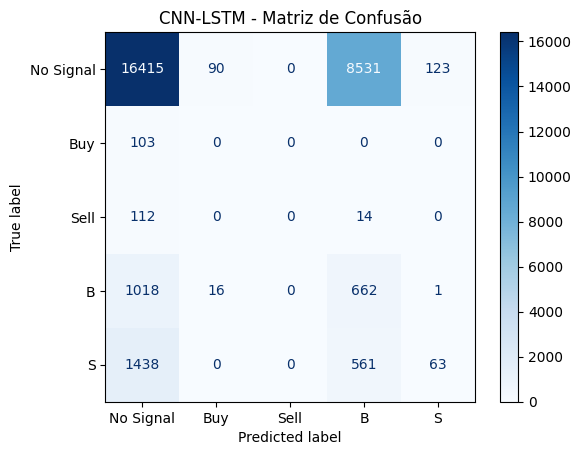

In [157]:
# Avaliação do modelo
loss, accuracy_cnn_lstm = cnn_lstm_model.evaluate(X_test_cnn_lstm, y_test_cnn_lstm)
print("Acurácia do CNN-LSTM:", accuracy_cnn_lstm)

# Previsões do CNN-LSTM
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test_cnn_lstm)
y_pred_cnn_lstm_classes = np.argmax(y_pred_cnn_lstm, axis=1)

# Ajustar y_test_classes para ter o mesmo tamanho de y_pred_cnn_classes
min_length = min(len(y_test_classes), len(y_pred_cnn_lstm_classes))

y_pred_cnn_lstm_classes = y_pred_cnn_lstm_classes[:min_length]

# Matriz de confusão - CNN-LSTM
cm_cnn_lstm = confusion_matrix(y_test_classes, y_pred_cnn_lstm_classes)
disp_cnn_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_lstm, display_labels=["No Signal", "Buy", "Sell","B","S"])
disp_cnn_lstm.plot(cmap="Blues")
plt.title("CNN-LSTM - Matriz de Confusão")
plt.show()